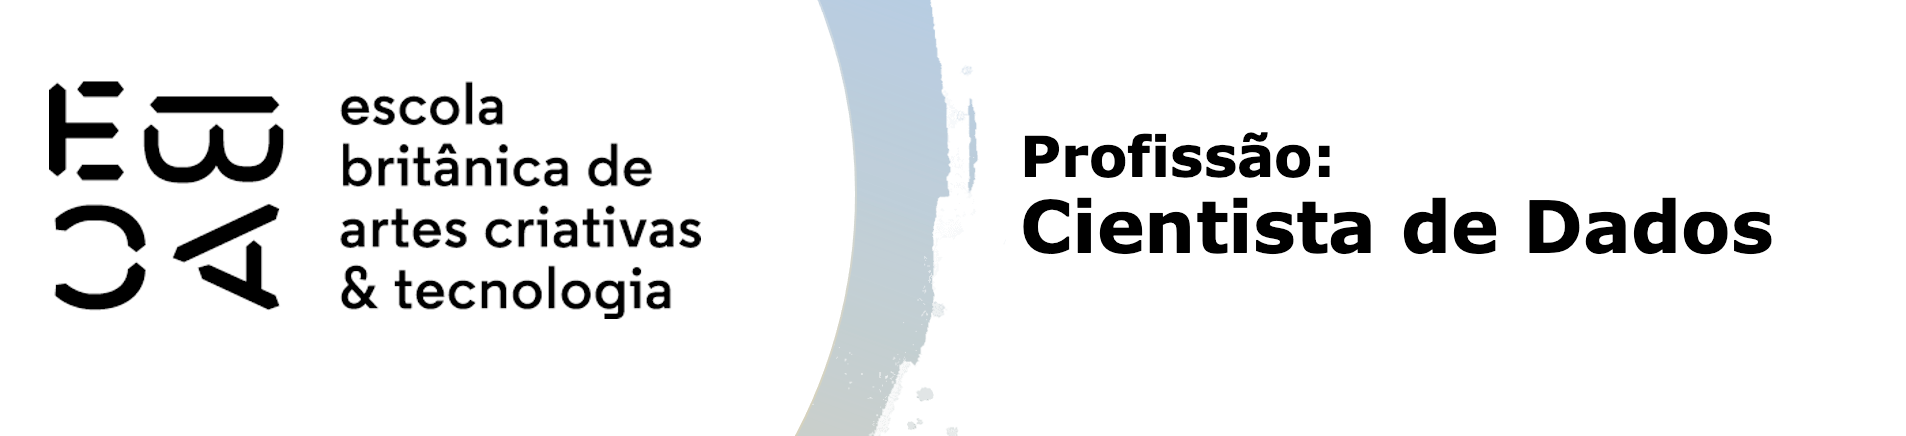

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np

df = pd.read_feather('credit_scoring.ftr')
df.shape
df

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
df = df.drop('index', axis=1)
df.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
# Converter 'data_ref' para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Separar os três últimos meses para validação *out of time*
last_three_months = df['data_ref'].max() - pd.DateOffset(months=3)
oot_df = df[df['data_ref'] >= last_three_months]
train_df = df[df['data_ref'] < last_three_months]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
# Número total de linhas
total_rows = len(df)

# Número de linhas para cada mês
monthly_counts = df['data_ref'].value_counts().sort_index()

total_rows, monthly_counts

(750000,
 data_ref
 2015-01-01    50000
 2015-02-01    50000
 2015-03-01    50000
 2015-04-01    50000
 2015-05-01    50000
 2015-06-01    50000
 2015-07-01    50000
 2015-08-01    50000
 2015-09-01    50000
 2015-10-01    50000
 2015-11-01    50000
 2015-12-01    50000
 2016-01-01    50000
 2016-02-01    50000
 2016-03-01    50000
 Name: count, dtype: int64)

In [5]:
# Descrição básica das variáveis quantitativas
quantitative_vars = df.select_dtypes(include=['float64', 'int64'])
quantitative_description = quantitative_vars.describe()

# Descrição básica das variáveis qualitativas
qualitative_vars = df.select_dtypes(include=['object'])
qualitative_description = {col: df[col].value_counts() for col in qualitative_vars.columns}

quantitative_description, qualitative_description


(          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
 count  750000.000000  750000.000000  624043.000000          750000.000000   
 mean        0.433251      43.804733       7.748574               2.212241   
 std         0.739379      11.229868       6.687455               0.903428   
 min         0.000000      22.000000       0.117808               1.000000   
 25%         0.000000      34.000000       3.049315               2.000000   
 50%         0.000000      43.000000       6.046575               2.000000   
 75%         1.000000      53.000000      10.183562               3.000000   
 max        14.000000      68.000000      42.906849              15.000000   
 
               renda  
 count  7.500000e+05  
 mean   2.323854e+04  
 std    7.910601e+04  
 min    1.076700e+02  
 25%    3.467700e+03  
 50%    7.861820e+03  
 75%    1.831828e+04  
 max    4.083986e+06  ,
 {'sexo': sexo
  F    504580
  M    245420
  Name: count, dtype: int64,
  'posse_de_veic

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

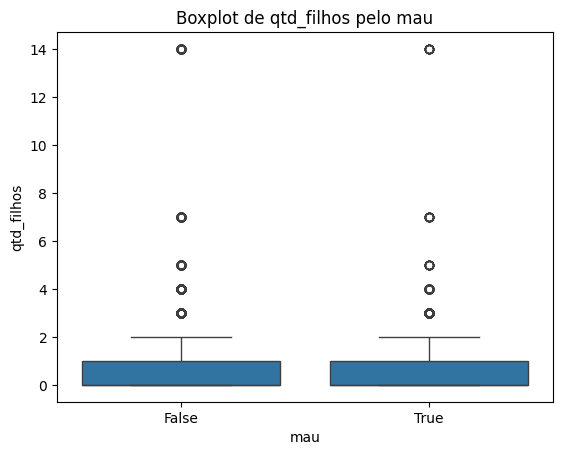

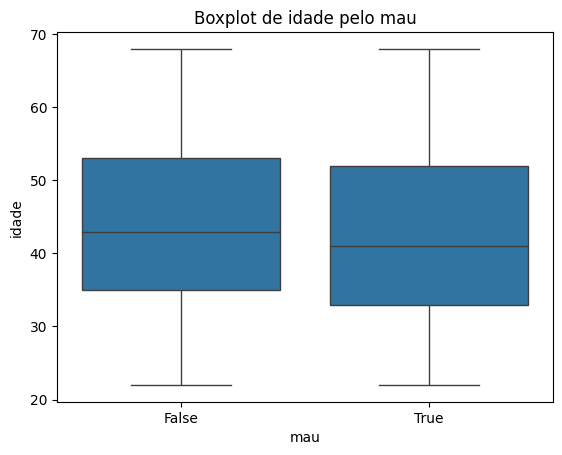

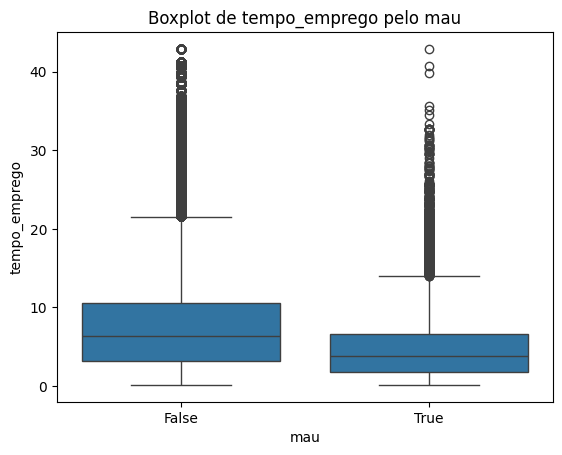

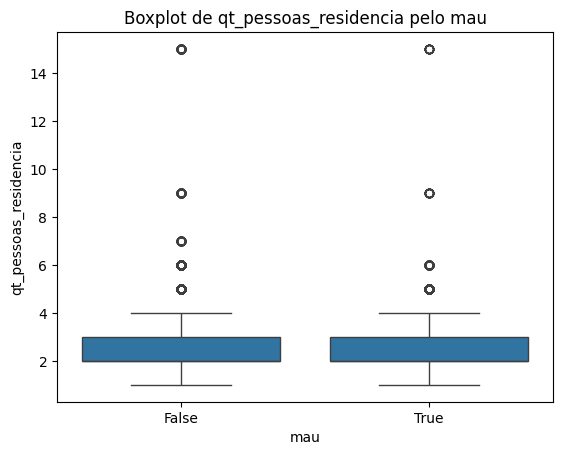

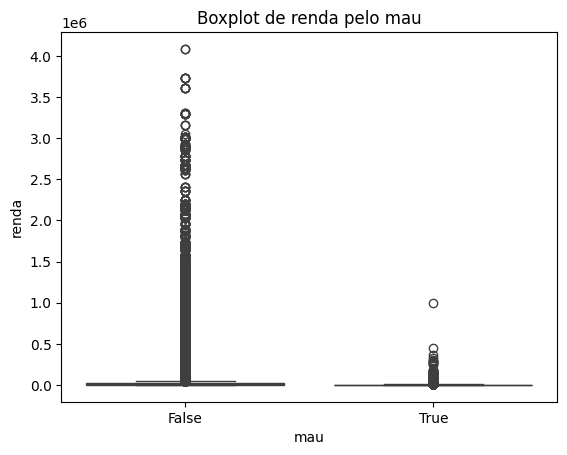

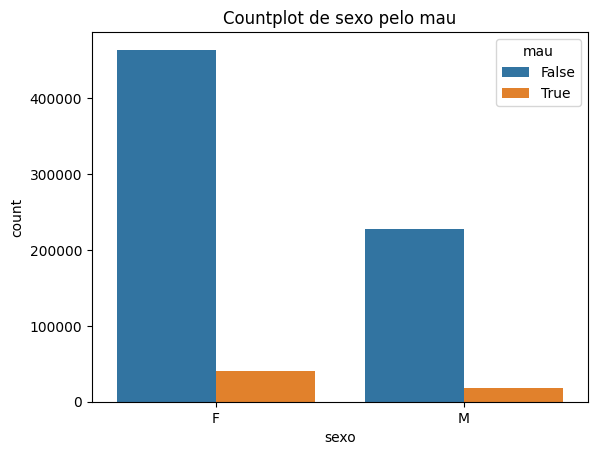

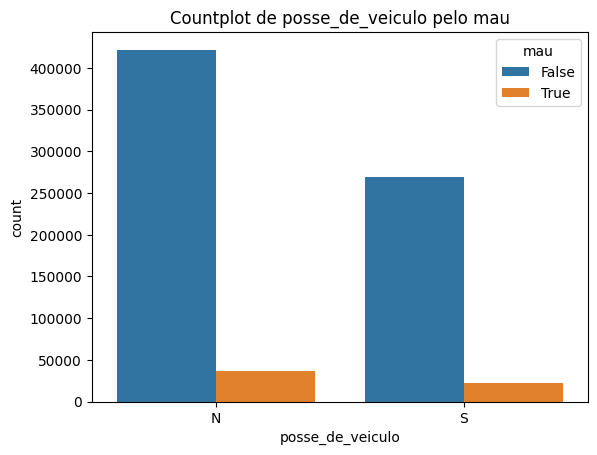

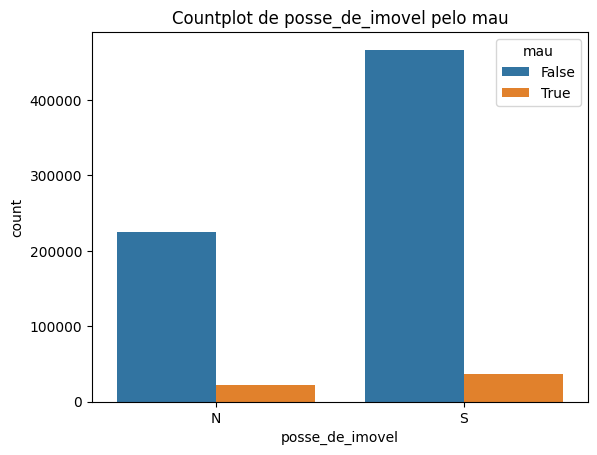

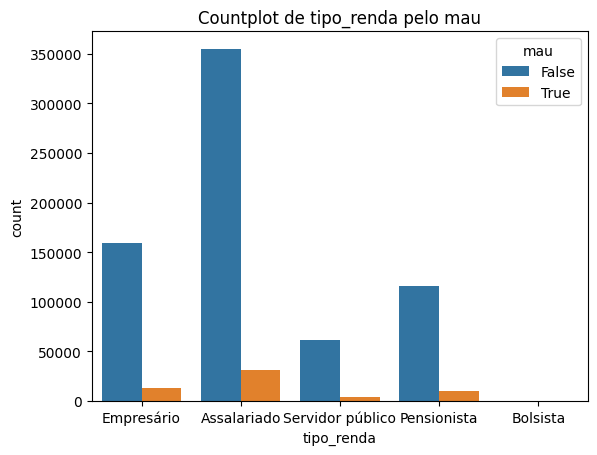

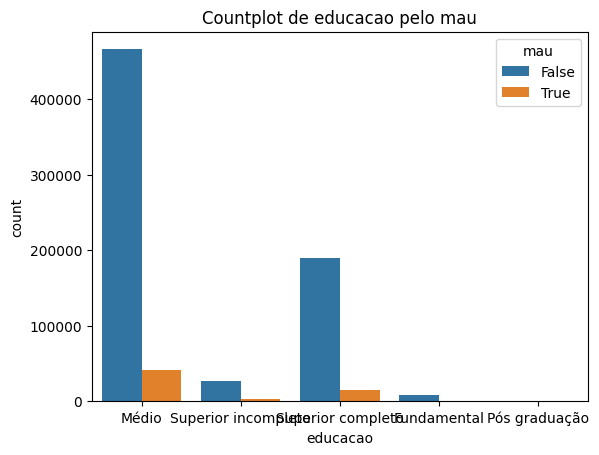

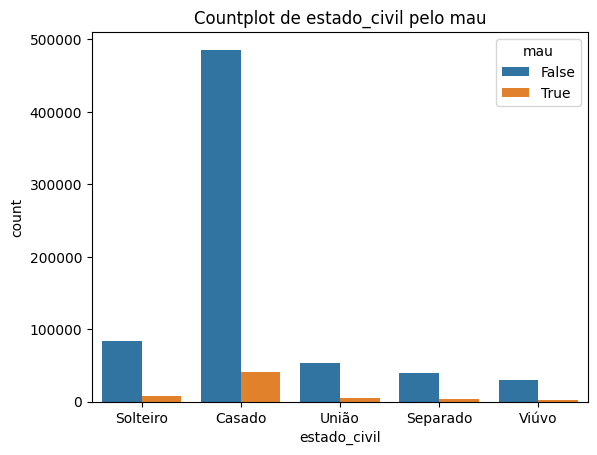

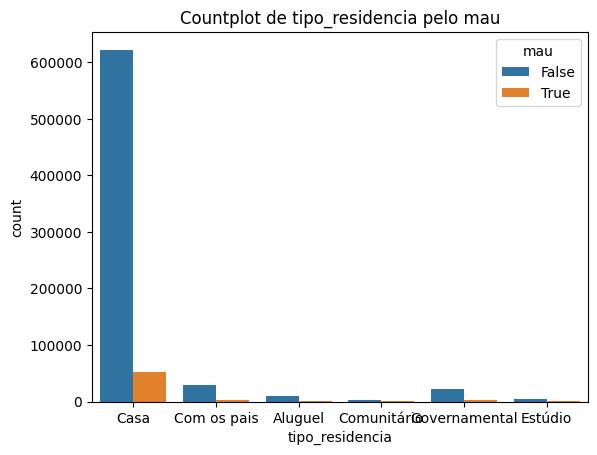

In [6]:
# Visualizações bivariadas
for col in quantitative_vars.columns:
    sns.boxplot(data=df, x='mau', y=col)
    plt.title(f'Boxplot de {col} pelo mau')
    plt.show()

# Para variáveis qualitativas vs. 'mau'
for col in qualitative_vars.columns:
    if col != 'data_ref' and col != 'index':
        sns.countplot(data=df, x=col, hue='mau')
        plt.title(f'Countplot de {col} pelo mau')
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   sexo                   750000 non-null  object        
 2   posse_de_veiculo       750000 non-null  object        
 3   posse_de_imovel        750000 non-null  object        
 4   qtd_filhos             750000 non-null  int64         
 5   tipo_renda             750000 non-null  object        
 6   educacao               750000 non-null  object        
 7   estado_civil           750000 non-null  object        
 8   tipo_residencia        750000 non-null  object        
 9   idade                  750000 non-null  int64         
 10  tempo_emprego          624043 non-null  float64       
 11  qt_pessoas_residencia  750000 non-null  float64       
 12  renda                  750000 non-null  floa

In [8]:
# Tratamento de valores missing
df = df.fillna({
    'tempo_emprego': df['tempo_emprego'].median()
})

# Exemplo de tratamento de outliers para uma variável quantitativa
df = df[(np.abs(stats.zscore(df['tempo_emprego'].fillna(df['tempo_emprego'].median()))) < 3)]


In [9]:
# Exemplos de tratamento de zeros estruturais
df['qtd_filhos'] = df['qtd_filhos'].replace(0, df['qtd_filhos'].mode()[0])


In [13]:
df['educacao'].value_counts()

data_ref    sexo  posse_de_veiculo  posse_de_imovel  qtd_filhos  tipo_renda        educacao           estado_civil  tipo_residencia  idade  tempo_emprego  qt_pessoas_residencia  renda     mau  
2016-03-01  M     N                 N                0           Empresário        Superior completo  Casado        Casa             50     5.602740       2.0                    7654.17   False    13
2015-12-01  F     N                 S                1           Servidor público  Médio              Casado        Casa             40     7.120548       3.0                    6974.34   False    12
2015-06-01  F     N                 S                0           Pensionista       Médio              Viúvo         Casa             68     6.046575       1.0                    7973.43   False    12
2015-02-01  M     S                 N                0           Empresário        Médio              Solteiro      Governamental    24     1.961644       1.0                    9064.52   False    12
2015-1

In [16]:
for column in df.columns:
    print(f"{column}: {df[column].value_counts().sort_values(ascending=False)}")

data_ref: data_ref
2015-06-01    48945
2015-10-01    48939
2015-01-01    48932
2015-11-01    48932
2016-02-01    48900
2015-08-01    48891
2015-09-01    48890
2015-04-01    48886
2015-07-01    48886
2015-12-01    48885
2016-03-01    48878
2015-05-01    48872
2015-03-01    48870
2016-01-01    48870
2015-02-01    48850
Name: count, dtype: int64
sexo: sexo
F    489554
M    243872
Name: count, dtype: int64
posse_de_veiculo: posse_de_veiculo
N    444571
S    288855
Name: count, dtype: int64
posse_de_imovel: posse_de_imovel
S    492972
N    240454
Name: count, dtype: int64
qtd_filhos: qtd_filhos
0     501912
1     152291
2      69207
3       8669
4       1065
7        101
5         95
14        86
Name: count, dtype: int64
tipo_renda: tipo_renda
Assalariado         374216
Empresário          170692
Pensionista         126265
Servidor público     61892
Bolsista               361
Name: count, dtype: int64
educacao: educacao
Médio                  494049
Superior completo      200942
Superior i

In [17]:
# Agrupamento de categorias menos frequentes
df['educacao'] = df['educacao'].replace({
    'Superior incompleto': 'Superior',
    
})


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [18]:
# Preparação dos dados
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 
             'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 
             'qt_pessoas_residencia', 'renda']
X = pd.get_dummies(df[features], drop_first=True)
y = df['mau']

# Dividir dados para treinamento e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

# Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

# Métricas
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
conf_matrix = confusion_matrix(y_valid, y_pred)

# Cálculo de KS e Gini
fpr, tpr, _ = roc_curve(y_valid, model.predict_proba(X_valid)[:, 1])
ks = max(tpr - fpr)
gini = 2 * roc_auc - 1



C:\Users\Xam_j\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# Exibir os resultados
print(f'Com uma acurácia de {(100*accuracy):.2f} %, o modelo está acertando a maioria das classificações, o que indica um bom desempenho geral na base de validação.')

print(f'Um AUC de {roc_auc:.4f} indica que o modelo tem uma boa capacidade de discriminação, sendo capaz de separar as classes com uma probabilidade de {(100*roc_auc):.1f}% para um classificador aleatório.')

print("\nMatriz de Confusão:")
print(conf_matrix)
print(f"\nKS: {ks:.4f}")
print(f"Gini: {gini:.4f}")

# Explicações
print("\nExplicações:")
print("Acurácia (Accuracy): Proporção de previsões corretas em relação ao total de previsões.")
print(f"   Valor: {accuracy:.4f}")

print("\nAUC-ROC (Área sob a Curva ROC): Mede a capacidade do modelo de distinguir entre as classes.")
print(f"   Valor: {roc_auc:.4f}")

print("\nMatriz de Confusão:")
print("   [TN, FP]")
print("   [FN, TP]")
print("   TN: Verdadeiros Negativos (clientes que não são inadimplentes e foram corretamente classificados).")
print("   FP: Falsos Positivos (clientes que não são inadimplentes mas foram classificados como inadimplentes).")
print("   FN: Falsos Negativos (clientes que são inadimplentes mas foram classificados como não inadimplentes).")
print("   TP: Verdadeiros Positivos (clientes que são inadimplentes e foram corretamente classificados como inadimplentes).")

print("\nKS (Kolmogorov-Smirnov): Mede a maior diferença entre as curvas de distribuição cumulativa das duas classes.")
print(f"   Valor: {ks:.4f}")

print("\nÍndice de Gini: Derivado do AUC-ROC, mede a desigualdade na distribuição das probabilidades preditivas.")
print(f"   Valor: {gini:.4f}")

Com uma acurácia de 92.07 %, o modelo está acertando a maioria das classificações, o que indica um bom desempenho geral na base de validação.
Um AUC de 0.7723 indica que o modelo tem uma boa capacidade de discriminação, sendo capaz de separar as classes com uma probabilidade de 77.2% para um classificador aleatório.

Matriz de Confusão:
[[202584      0]
 [ 17444      0]]

KS: 0.4088
Gini: 0.5447

Explicações:
Acurácia (Accuracy): Proporção de previsões corretas em relação ao total de previsões.
   Valor: 0.9207

AUC-ROC (Área sob a Curva ROC): Mede a capacidade do modelo de distinguir entre as classes.
   Valor: 0.7723

Matriz de Confusão:
   [TN, FP]
   [FN, TP]
   TN: Verdadeiros Negativos (clientes que não são inadimplentes e foram corretamente classificados).
   FP: Falsos Positivos (clientes que não são inadimplentes mas foram classificados como inadimplentes).
   FN: Falsos Negativos (clientes que são inadimplentes mas foram classificados como não inadimplentes).
   TP: Verdadeir